<a href="https://colab.research.google.com/github/MateuszOszczypala/Data_public/blob/main/Particle_swarm_optimization_RAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import drive
from itertools import combinations
from scipy.spatial.distance import pdist

In [ ]:
# Basic parameters of PSO
number_of_iterations = 10000
swarm_size = 200
lb = 0
ub = 255
lb2 = -0.5
ub2 = 5.5-10e-06
inertia_weight = 0.95
personal_best_weight = 0.3
global_best_weight = 0.5

In [ ]:
# Basic parameters of system
number_of_subsystems = 10
working_failure_rate = [0.8147, 0.9058, 0.1270, 0.9134, 0.6324, 0.0975, 0.2785, 0.5469, 0.9575, 0.9649]
standby_failure_rate = [0.0943, 0.1049, 0.0147, 0.1057, 0.0732, 0.0113, 0.0322, 0.0633, 0.1108, 0.1117]
repair_rate = [2.9412, 2.9143, 1.9708, 2.6006, 1.2838, 1.8435, 2.8315, 2.5844, 2.9190, 2.3115]
warm_standby_switching_rate = [5.3571, 13.4913, 14.3399, 11.7874, 2.5774, 12.4313, 8.9223, 11.5548, 6.7119, 12.0605]
cold_standby_switching_rate = [2.6785, 6.7457, 7.1700, 5.8937, 1.2887, 6.2157, 4.4611, 5.7774, 3.3559, 6.0302]
k = [3, 3, 1, 1, 2, 2, 1, 1, 3, 3]
unit_cost = [5.67, 8.36, 8.57, 4.31, 6.43, 6.12, 7.52, 7.97, 8.28, 4.93]
unit_weight = [5.22, 6.94, 5.32, 5.68, 10.76, 9.86, 7.22, 11.65, 5.24, 8.07]

In [ ]:
# Constraints
weight_constraint = 400
cost_constraint = 350

In [ ]:
def Create_CTMC_model_no_redundancy(n, working_failure_rate, repair_rate): # strategy 0
  # Initialize CTMC matrix
  CTMC = np.zeros((2, 2))
  # State no. 0 is subsystem working state
  # State no. 1 is subsystem failure state

  # Transition rates
  CTMC[0, 1] = n*working_failure_rate # Failure of working component
  CTMC[1, 0] = repair_rate # Repair
  CTMC[0, 0] = -n*working_failure_rate # diagonal
  CTMC[1, 1] = -repair_rate # diagonal
  return CTMC

In [ ]:
def Create_CTMC_model_hot_standby(n, k, working_failure_rate, repair_rate): # strategy 1
  State_space = np.empty((n-k+2, 3), dtype=int)
  # States no. from 0 to n-k are subsystem working states
  # State no. n-k+1 is subsystem failure state

  # Working states with k working components and remaining in hot standby or failed
  j = 0
  for i in range(n-k+1):
    State_space[i, 0] = k # number of working components
    State_space[i, 1] = n-k-j # number of hot standby components
    State_space[i, 2] = j # number of failed components
    j += 1
  # Failure states with k-1 operational components and n-k+1 failed components
    State_space[n-k+1, 0] = k-1 # number of working components
    State_space[n-k+1, 1] = 0 # number of hot standby components
    State_space[n-k+1, 2] = n-k+1 # number of failed components

  # Initialize CTMC matrix
  CTMC = np.zeros((n-k+2, n-k+2))

  # Transition rates
  for i in range(n-k+2):
    for j in range(n-k+2):
      if State_space[i, 0] - State_space[j, 0] == 1: # Failure of working component
        CTMC[i, j] = State_space[i, 0] * working_failure_rate
      elif State_space[i, 2] - State_space[j, 2] == 1: # Repair
        CTMC[i, j] = State_space[i, 2] * repair_rate

    # Diagonal elements
  for i in range(n-k+2):
    CTMC[i, i] = -np.sum(CTMC[i, :])

  return CTMC

In [ ]:
def Create_CTMC_model_warm_standby(n, k, working_failure_rate, standby_failure_rate, repair_rate, switching_rate): # strategy 2
  State_space = np.empty((2*n-2*k+3, 3), dtype=int)
  # States no. from 0 to n-k are subsystem working states
  # States no. form n-k+1 to 2n-2k+2 are subsystem failure states

  # Working states with k working components and remaining in warm standby or failed
  j = 0
  for i in range(n-k+1):
    State_space[i, 0] = k # number of working components
    State_space[i, 1] = n-k-j # number of warm standby components
    State_space[i, 2] = j # number of failed components
    j += 1
  # Failure states with k-1 operational components and n-k+1 failed components
  j = 0
  for i in range(n-k+1, 2*n-2*k+3):
    State_space[i, 0] = k-1 # number of working components
    State_space[i, 1] = n-k+1-j # number of warm standby components
    State_space[i, 2] = j # number of failed components
    j += 1

  # Initialize CTMC matrix
  CTMC = np.zeros((2*n-2*k+3, 2*n-2*k+3))

  # Transition rates
  for i in range(2*n-2*k+3):
    for j in range(2*n-2*k+3):
      if State_space[i, 0] - State_space[j, 0] == 1 and State_space[j, 2] - State_space[i, 2] == 1:  # Failure of working component
        CTMC[i, j] = State_space[i, 0] * working_failure_rate
      elif State_space[i, 1] - State_space[j, 1] == 1 and State_space[j, 2] - State_space[i, 2] == 1:  # Failure of warm standby component
        if State_space[i, 0] == k - 1:
          # CTMC[i, j] = (State_space[i, 1] + State_space[i, 0]) * standby_failure_rate
          CTMC[i, j] = 0 # according to the assumption of non-failing components in subsystem failure state
        else:
          CTMC[i, j] = State_space[i, 1] * standby_failure_rate
      elif State_space[i, 1] - State_space[j, 1] == 1 and State_space[j, 0] - State_space[i, 0] == 1:  # Switch
        CTMC[i, j] = switching_rate
      elif State_space[i, 2] - State_space[j, 2] == 1 and State_space[j, 1] - State_space[i, 1] == 1:  # Repair
        CTMC[i, j] = State_space[i, 2] * repair_rate

    # Diagonal elements
  for i in range(2*n-2*k+3):
    CTMC[i, i] = -np.sum(CTMC[i, :])

  return CTMC

In [ ]:
def Create_CTMC_model_cold_standby(n, k, working_failure_rate, repair_rate, switching_rate): # strategy 3
  State_space = np.empty((2*n-2*k+3, 3), dtype=int)
  # States no. from 0 to n-k are subsystem working states
  # States no. form n-k+1 to 2n-2k+2 are subsystem failure states

  # Working states with k working components and remaining in cold standby or failed
  j = 0
  for i in range(n-k+1):
    State_space[i, 0] = k # number of working components
    State_space[i, 1] = n-k-j # number of cold standby components
    State_space[i, 2] = j # number of failed components
    j += 1
  # Failure states with k-1 operational components and n-k+1 failed components
  j = 0
  for i in range(n-k+1, 2*n-2*k+3):
    State_space[i, 0] = k-1 # number of working components
    State_space[i, 1] = n-k+1-j # number of cold standby components
    State_space[i, 2] = j # number of failed components
    j += 1

  # Initialize CTMC matrix
  CTMC = np.zeros((2*n-2*k+3, 2*n-2*k+3))

  # Transition rates
  for i in range(2*n-2*k+3):
    for j in range(2*n-2*k+3):
      if State_space[i, 0] - State_space[j, 0] == 1 and State_space[j, 2] - State_space[i, 2] == 1:  # Failure of working component
        CTMC[i, j] = State_space[i, 0] * working_failure_rate
      elif State_space[i, 1] - State_space[j, 1] == 1 and State_space[j, 0] - State_space[i, 0] == 1:  # Switch
        CTMC[i, j] = switching_rate
      elif State_space[i, 2] - State_space[j, 2] == 1 and State_space[j, 1] - State_space[i, 1] == 1:  # Repair
        CTMC[i, j] = State_space[i, 2] * repair_rate

    # Diagonal elements
  for i in range(2*n-2*k+3):
    CTMC[i, i] = -np.sum(CTMC[i, :])

  return CTMC

In [ ]:
def Create_CTMC_model_mixed_strategy_active_warm(n, k, working_failure_rate, standby_failure_rate, repair_rate, switching_rate): # strategy 4
  State_space = np.empty((3*n-3*k+3, 3), dtype=int)

  j = 0
  # Working states with k+1 active components
  for i in range(n-k):
    State_space[i, 0] = k+1 # number of working components
    State_space[i, 1] = n-k-1-j # number of hot standby components
    State_space[i, 2] = j # number of failed components
    j += 1
  j = 0
  # Working states with k active components
  for i in range(n-k, 2*n-2*k+1):
    State_space[i, 0] = k # number of working components
    State_space[i, 1] = n-k-j # number of hot standby components
    State_space[i, 2] = j # number of failed components
    j += 1

  j = 0
    # Failed states with k-1 active components
  for i in range(2*n-2*k+1, 3*n-3*k+3):
    State_space[i, 0] = k-1 # number of working components
    State_space[i, 1] = n-k+1-j # number of hot standby components
    State_space[i, 2] = j # number of failed components
    j += 1

  # Initialize CTMC matrix
  CTMC = np.zeros((3*n-3*k+3, 3*n-3*k+3))

  # Transition rates
  for i in range(3*n-3*k+3):
    for j in range(3*n-3*k+3):
      if State_space[i, 0] - State_space[j, 0] == 1 and State_space[j, 2] - State_space[i, 2] == 1:  # Failure of active component
        CTMC[i, j] = State_space[i, 0] * working_failure_rate
      elif State_space[i, 1] - State_space[j, 1] == 1 and State_space[j, 2] - State_space[i, 2] == 1:  # Failure of warm standby component
        if State_space[i, 0] == k - 1:
          # CTMC[i, j] = (State_space[i, 1] + State_space[i, 0]) * standby_failure_rate
          CTMC[i, j] = 0 # according to the assumption of non-failing components in subsystem failure state
        else:
          CTMC[i, j] = State_space[i, 1] * standby_failure_rate
      elif State_space[i, 1] - State_space[j, 1] == 1 and State_space[j, 0] - State_space[i, 0] == 1:  # Switch
        CTMC[i, j] = (min(min(State_space[i, 1], 2), k + 1 - State_space[i, 0])) * switching_rate
      elif State_space[i, 2] - State_space[j, 2] == 1 and State_space[j, 1] - State_space[i, 1] == 1:  # Repair
        CTMC[i, j] = State_space[i, 2] * repair_rate

    # Diagonal elements
  for i in range(3*n-3*k+3):
    CTMC[i, i] = -np.sum(CTMC[i, :])

  return CTMC

In [ ]:
def Create_CTMC_model_mixed_strategy_active_cold(n, k, working_failure_rate, repair_rate, switching_rate): # strategy 5
  State_space = np.empty((3*n-3*k+3, 3), dtype=int)

  j = 0
  # Working states with k+1 active components
  for i in range(n-k):
    State_space[i, 0] = k+1 # number of working components
    State_space[i, 1] = n-k-1-j # number of hot standby components
    State_space[i, 2] = j # number of failed components
    j += 1
  j = 0
  # Working states with k active components
  for i in range(n-k, 2*n-2*k+1):
    State_space[i, 0] = k # number of working components
    State_space[i, 1] = n-k-j # number of hot standby components
    State_space[i, 2] = j # number of failed components
    j += 1

  j = 0
    # Failed states with k-1 active components
  for i in range(2*n-2*k+1, 3*n-3*k+3):
    State_space[i, 0] = k-1 # number of working components
    State_space[i, 1] = n-k+1-j # number of hot standby components
    State_space[i, 2] = j # number of failed components
    j += 1

  # Initialize CTMC matrix
  CTMC = np.zeros((3*n-3*k+3, 3*n-3*k+3))

  # Transition rates
  for i in range(3*n-3*k+3):
    for j in range(3*n-3*k+3):
      if State_space[i, 0] - State_space[j, 0] == 1 and State_space[j, 2] - State_space[i, 2] == 1:  # Failure of active component
        CTMC[i, j] = State_space[i, 0] * working_failure_rate
      elif State_space[i, 1] - State_space[j, 1] == 1 and State_space[j, 0] - State_space[i, 0] == 1:  # Switch
        CTMC[i, j] = (min(min(State_space[i, 1], 2), k + 1 - State_space[i, 0])) * switching_rate
      elif State_space[i, 2] - State_space[j, 2] == 1 and State_space[j, 1] - State_space[i, 1] == 1:  # Repair
        CTMC[i, j] = State_space[i, 2] * repair_rate

    # Diagonal elements
  for i in range(3*n-3*k+3):
    CTMC[i, i] = -np.sum(CTMC[i, :])

  return CTMC

In [ ]:
def Ergodic_probabilities(CTMC):
  CTMC_transposed = CTMC.T
  CTMC_transposed[0, :CTMC_transposed.shape[0]] = 1
  P = np.zeros((CTMC_transposed.shape[0], 1))
  P[0, 0] = 1
  Ergodic_prob = np.linalg.inv(CTMC_transposed) @ P
  return Ergodic_prob

In [ ]:
def Availability_of_subsystems(n, k, Ergodic_prob, redundancy_strategy):

  if redundancy_strategy == 0: # no redundancy
    Subsystem_availabilities = np.sum(Ergodic_prob[0:1])

  elif redundancy_strategy == 1: # hot standby
    Subsystem_availabilities = np.sum(Ergodic_prob[0:n-k+1])

  elif redundancy_strategy == 2: # warm standby
    Subsystem_availabilities = np.sum(Ergodic_prob[0:n-k+1])

  elif redundancy_strategy == 3: # cold standby
    Subsystem_availabilities = np.sum(Ergodic_prob[0:n-k+1])

  elif redundancy_strategy == 4: # mixed strategy(active + warm)
    Subsystem_availabilities = np.sum(Ergodic_prob[0:2*n-2*k+1])

  elif redundancy_strategy == 5: # mixed strategy(active + cold)
    Subsystem_availabilities = np.sum(Ergodic_prob[0:2*n-2*k+1])

  return Subsystem_availabilities

In [ ]:
def objective_function(Subsystem_availabilities):
  A = Subsystem_availabilities
  U = 1 - A
  System_availability = (
        A[0]*A[1]*A[2]*A[3]+
        A[0]*A[1]*A[5]*A[9]*(U[2]+A[2]*U[3])+
        A[0]*A[4]*A[8]*A[9]*(U[1]+A[1]*U[2]*U[5]+A[1]*A[2]*U[3]*U[5])+
        A[6]*A[7]*A[8]*A[9]*(U[0]+A[0]*U[1]*U[4]+A[0]*A[1]*U[2]*U[4]*U[5]+A[0]*A[1]*A[2]*U[3]*U[4]*U[5])+
        A[1]*A[2]*A[3]*A[4]*A[6]*A[7]*U[0]*(U[8]+A[8]*U[9])+
        U[0]*A[2]*A[3]*A[5]*A[6]*A[7]*A[8]*U[9]*(U[1]+A[1]*U[4])+
        A[0]*U[1]*A[2]*A[3]*A[5]*A[6]*A[7]*A[8]*A[9]*U[9]+
        A[0]*U[1]*A[2]*A[3]*A[4]*A[5]*A[8]*U[9]*(U[6]+A[6]*U[7])+
        U[0]*A[1]*A[4]*A[5]*A[6]*A[7]*A[8]*U[8]*A[9]*(U[2]+A[2]*U[3])
    )
  return System_availability

In [ ]:
def component_allocation(redundancy_strategy, priority, weight_available, unit_weight, cost_available, unit_cost):
  a = np.zeros(priority.shape[0])
  for i in range(priority.shape[0]):
    a[i] = priority[i]/255
  standby_components = np.zeros(priority.shape[0], dtype=int)

  for i in range(priority.shape[0]):
    if redundancy_strategy[i] == 0: # no redundancy
      standby_components[i] = 0
    else:
      standby_components[i] = round(a[i] * min(round(weight_available/unit_weight[i]),round(cost_available/unit_cost[i])))
  return standby_components

In [ ]:
# Initialization
def initialization(number_of_subsystems, swarm_size, lb, ub, lb2, ub2):
  initial_swarm = np.empty((4, number_of_subsystems, swarm_size), dtype=float)
  initial_swarm[0, :, :] = np.random.uniform(lb, ub, (1, number_of_subsystems, swarm_size))
  initial_swarm[1, :, :] = np.random.randint(lb2, ub2, (1, number_of_subsystems, swarm_size))
  initial_swarm[2, :, :] = np.random.randint(lb, ub, (1, number_of_subsystems, swarm_size))
  initial_swarm[3, :, :] = np.random.randint(lb2, ub2, (1, number_of_subsystems, swarm_size))

  return initial_swarm

In [ ]:
# Particle swarm optimization
particle_positions = np.empty((2, number_of_subsystems, swarm_size, number_of_iterations), dtype=float)
particle_velocities = np.empty((2, number_of_subsystems, swarm_size, number_of_iterations), dtype=float)
objective_function_value = np.full((swarm_size, number_of_iterations), np.nan)
n = np.full((number_of_subsystems, swarm_size, number_of_iterations), np.nan)
redundancy_strategy = np.full((number_of_subsystems, swarm_size, number_of_iterations), np.nan)
personal_best_availability = np.full((swarm_size, number_of_iterations), np.nan)
personal_best_position = np.full((2, number_of_subsystems, swarm_size, number_of_iterations), np.nan)
global_best_availability = np.full((number_of_iterations), np.nan)
global_best_position = np.full((2, number_of_subsystems, number_of_iterations), np.nan)

# Initialization
initial_swarm = initialization(number_of_subsystems, swarm_size, lb, ub, lb2, ub2)
particle_positions[:,:,:,0] = initial_swarm[0:2,:,:]
particle_velocities[:,:,:,0] = initial_swarm[2:4,:,:]

available_weight = 0
for i in range(number_of_subsystems):
  available_weight += k[i]*unit_weight[i]

available_cost = 0
for i in range(number_of_subsystems):
  available_cost += k[i]*unit_cost[i]

for num_it in range(number_of_iterations):
  for num_particle in range(swarm_size):

        # identify the redundancy strategy
    for i in range(number_of_subsystems):
      redundancy_strategy[i, num_particle, num_it] = round(particle_positions[1, i, num_particle, num_it])

       # allocate standby components to subsystems
    standby_components = component_allocation(redundancy_strategy[:, num_particle, num_it], particle_positions[0, :, num_particle, num_it], available_weight, unit_weight, available_cost, unit_cost)
    n_components = np.zeros(number_of_subsystems, dtype=int)
    for i in range(number_of_subsystems):
      n[i, num_particle, num_it] = k[i] + int(standby_components[i])
      n_components[i] = k[i] + int(standby_components[i])

    # calculate subsystem availabilities
    Subsystem_availabilities = np.full((number_of_subsystems), np.nan)

    for num_subsystem in range(number_of_subsystems):
      if redundancy_strategy[num_subsystem, num_particle, num_it] == 0:
        CTMC = Create_CTMC_model_no_redundancy(n_components[num_subsystem], working_failure_rate[num_subsystem], repair_rate[num_subsystem])

      elif redundancy_strategy[num_subsystem, num_particle, num_it] == 1:
        CTMC = Create_CTMC_model_hot_standby(n_components[num_subsystem], k[num_subsystem], working_failure_rate[num_subsystem], repair_rate[num_subsystem])

      elif redundancy_strategy[num_subsystem, num_particle, num_it] == 2:
        CTMC = Create_CTMC_model_warm_standby(n_components[num_subsystem], k[num_subsystem], working_failure_rate[num_subsystem], standby_failure_rate[num_subsystem], repair_rate[num_subsystem], warm_standby_switching_rate[num_subsystem])

      elif redundancy_strategy[num_subsystem, num_particle, num_it] == 3:
        CTMC = Create_CTMC_model_cold_standby(n_components[num_subsystem], k[num_subsystem], working_failure_rate[num_subsystem], repair_rate[num_subsystem], cold_standby_switching_rate[num_subsystem])

      elif redundancy_strategy[num_subsystem, num_particle, num_it] == 4:
        CTMC = Create_CTMC_model_mixed_strategy_active_warm(n_components[num_subsystem], k[num_subsystem], working_failure_rate[num_subsystem], standby_failure_rate[num_subsystem], repair_rate[num_subsystem], warm_standby_switching_rate[num_subsystem])

      elif redundancy_strategy[num_subsystem, num_particle, num_it] == 5:
        CTMC = Create_CTMC_model_mixed_strategy_active_cold(n_components[num_subsystem], k[num_subsystem], working_failure_rate[num_subsystem], repair_rate[num_subsystem], cold_standby_switching_rate[num_subsystem])

      Ergodic_prob = Ergodic_probabilities(CTMC)
      Subsystem_availabilities[num_subsystem] = Availability_of_subsystems(n_components[num_subsystem], k[num_subsystem], Ergodic_prob, redundancy_strategy[num_subsystem, num_particle, num_it])

      del CTMC, Ergodic_prob
    # objective value (system availability) calculation
    if np.sum(n[:, num_particle, num_it]*unit_cost) > cost_constraint or np.sum(n[:, num_particle, num_it]*unit_weight) > weight_constraint:
      num_components = np.full((number_of_subsystems), np.nan)
      for i in range(number_of_subsystems):
        num_components[i] = n[i, num_particle, num_it]
        system_cost = 0
      for i in range(number_of_subsystems):
        system_cost = system_cost + num_components[i]*unit_cost[i]
        system_weight = 0
      for i in range(number_of_subsystems):
        system_weight = system_weight + num_components[i]*unit_weight[i]
      if system_cost/cost_constraint > system_weight/weight_constraint:
        penalty_function = 0.01**(system_cost/cost_constraint)
      else:
        penalty_function = 0.01**(system_weight/weight_constraint)
      objective_function_value[num_particle, num_it] = objective_function(Subsystem_availabilities)*penalty_function
    else:
      objective_function_value[num_particle, num_it] = objective_function(Subsystem_availabilities)

  for i in range(swarm_size):
    personal_best_availability[i, num_it] = np.max(objective_function_value[i, :num_it+1])

  global_best_availability[num_it] = np.max(personal_best_availability)

  for i in range(swarm_size):
    best_index = np.argmax(objective_function_value[i, :num_it+1])
    personal_best_position[:, :, i, num_it] = particle_positions[:, :, i, best_index]

  best_global_particle, best_global_index = np.unravel_index(np.argmax(objective_function_value[:, :num_it+1]), objective_function_value[:, :num_it+1].shape)
  global_best_position[:, :, num_it] = particle_positions[:, :, best_global_particle, best_global_index]

  if num_it < number_of_iterations-1:
    for j in range(swarm_size):
        if np.array_equal(particle_positions[:, :, j, num_it], global_best_position[:, :, num_it]): # elitism
          particle_velocities[:, :, j, num_it+1] = particle_velocities[:, :, j, num_it]
          particle_positions[:, :, j, num_it+1] = particle_positions[:, :, j, num_it]
        else:
          for i in range(number_of_subsystems):
              rand1, rand2 = np.random.rand(), np.random.rand()
              particle_velocities[:, i, j, num_it+1] = (
                  inertia_weight * particle_velocities[:, i, j, num_it] +
                  personal_best_weight * rand1 * (personal_best_position[:, i, j, num_it] - particle_positions[:, i, j, num_it]) +
                  global_best_weight * rand2 * (global_best_position[:, i, num_it] - particle_positions[:, i, j, num_it])
                )
              particle_positions[:, i, j, num_it+1] = particle_positions[:, i, j, num_it] + particle_velocities[:, i, j, num_it+1]
              particle_positions[0, i, j, num_it+1] = max(min(particle_positions[0, i, j, num_it+1], ub), lb)
              particle_positions[1, i, j, num_it+1] = max(min(particle_positions[1, i, j, num_it+1], ub2), lb2)

In [ ]:
print(redundancy_strategy[num_subsystem, num_particle, num_it])

5.0


In [ ]:
print(global_best_position[:,:,0])

[[162.17149192  75.6997309  140.5901635  122.72309587 106.47299069
  173.47202161 113.77201823   3.70348611  43.04580034  41.31696448]
 [  0.           1.           0.           3.           0.
    0.           0.           0.           2.           3.        ]]


In [ ]:
print(np.max(personal_best_availability))
global_best_availability = np.max(personal_best_availability)
print(global_best_availability)

0.9715494454456547
0.9715494454456547


In [ ]:
print(personal_best_availability[:,90])

[0.96620519 0.97036113 0.96471354 0.94999785 0.97112774 0.9686426
 0.96938103 0.96960269 0.97051988 0.97072066 0.96656711 0.96969574
 0.97016034 0.96734498 0.96001393 0.92535259 0.96029072 0.94932953
 0.9710361  0.95140768 0.95011248 0.96102934 0.94925493 0.96896343
 0.96676919 0.93557156 0.97154945 0.97133398 0.97016034 0.96918417
 0.96665368 0.97100152 0.96955623 0.96634066 0.9530801  0.97154945
 0.96538085 0.96333863 0.96895411 0.96339786 0.95085147 0.94791235
 0.95902322 0.94432793 0.96674134 0.96697595 0.97069752 0.96592427
 0.96729997 0.9459808  0.96654436 0.96289205 0.96438946 0.96973364
 0.97100152 0.97120254 0.95019232 0.96964673 0.96833892 0.9686543
 0.95863326 0.96505824 0.9530801  0.94527591 0.97011484 0.97036996
 0.95212307 0.96265692 0.9515087  0.96714107 0.97154945 0.96796762
 0.96659908 0.96713217 0.95072239 0.9503316  0.97028352 0.96278056
 0.97154945 0.97154945 0.97090663 0.96315059 0.95184105 0.96895411
 0.95574803 0.96978872 0.96652043 0.96223183 0.91956221 0.966728

In [ ]:
print(global_best_position[:, :, num_it])

[[155.89534543  84.23655857 255.          72.92643326 255.
  255.         255.           0.          64.18093697  65.83458657]
 [  0.62557435   3.85103212  -0.5          1.16636463  -0.5
   -0.5         -0.5         -0.5          4.16662862   5.48613216]]


In [ ]:
print(personal_best_position[:, :, :, num_it])

[[[155.89534543 158.45688449 158.93074869 ... 164.67305906 155.86746683
   156.00708074]
  [ 84.23655857  81.07590342  79.82502482 ...  81.3804921   78.55262876
    87.02919954]
  [255.         255.         251.48007371 ... 251.81021696 251.58205573
   255.        ]
  ...
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [ 64.18093697  63.73571399  62.8661792  ...  65.29663626  58.63931654
    69.91256778]
  [ 65.83458657  66.58826585  65.46299113 ...  70.25502559  65.49763002
    73.60711822]]

 [[  0.62557435   0.5694826    0.57504424 ...   0.62836351   0.87482385
     0.72676925]
  [  3.85103212   3.85211484   3.78958405 ...   3.7274637    4.22086144
     3.90505192]
  [ -0.5         -0.5         -0.5        ...  -0.5         -0.5
    -0.5       ]
  ...
  [ -0.5         -0.5         -0.5        ...  -0.5         -0.5
    -0.5       ]
  [  4.16662862   4.16788813   4.20544829 ...   4.33347389   4.35632127
     3.9649353 ]
  [  5.48613216   5.4879739  

In [ ]:
print(particle_positions[0, 0, 0, :20])

[237.15956693 255.         255.         255.         255.
 232.89119928 178.83822213 137.79693968 138.58204723 151.21369502
 190.59846969 224.52240868 240.62364483 221.63315459 189.71314451
 161.62370021 148.49341858 135.50127188 139.08980384 158.8454431 ]


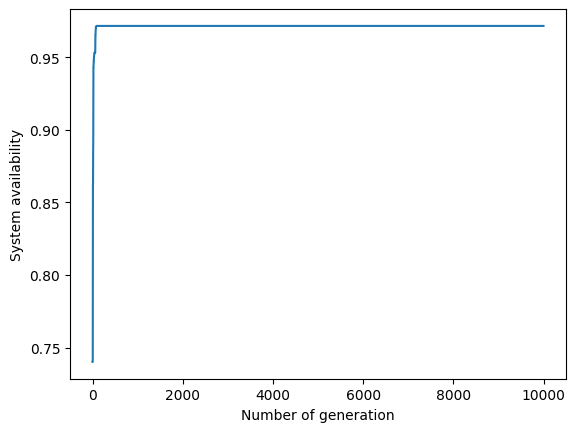

In [ ]:
plt.plot(np.max(objective_function_value, axis=0))
plt.xlabel('Number of generation')
plt.ylabel('System availability')
plt.show()

In [ ]:
print(np.nanmax(objective_function_value))
print(np.unravel_index(np.argmax(objective_function_value), objective_function_value.shape))
print(redundancy_strategy[:,np.unravel_index(np.argmax(objective_function_value), objective_function_value.shape)[0],np.unravel_index(np.argmax(objective_function_value), objective_function_value.shape)[1]])
print(n[:,np.unravel_index(np.argmax(objective_function_value), objective_function_value.shape)[0],np.unravel_index(np.argmax(objective_function_value), objective_function_value.shape)[1]])
print(k)

0.9715494454456547
(0, 203)
[1. 4. 0. 1. 0. 0. 0. 0. 4. 5.]
[18.  8.  1.  8.  2.  2.  1.  1.  7.  8.]
[3, 3, 1, 1, 2, 2, 1, 1, 3, 3]
